# What is torch.nn really?

From https://pytorch.org/tutorials/beginner/nn_tutorial.html?highlight=mnist.

First, let's download some datasets.

In [1]:
from pathlib import Path
import os
import requests

DATA_PATH = Path("../data/external")
PATH = DATA_PATH / "mnist"

# Good lord, SSL cert expired in 2013
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not(PATH / FILENAME).exists():
    try:
        os.mkdir(PATH)
    except FileExistsError:
        pass
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Is it there?

In [2]:
!ls ../data/external/mnist
!file ../data/external/mnist/mnist.pkl.gz

mnist.pkl.gz
../data/external/mnist/mnist.pkl.gz: gzip compressed data, was "mnist.pkl", last modified: Thu Jan 14 17:32:04 2010, max compression, original size modulo 2^32 220080342


Good!

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    # I'm not sure why we're dropping the third item here.
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Let's look at a sample.

(50000, 784)


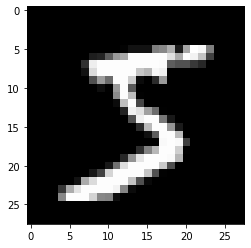

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

We need to convert this to tensors.

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

x_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

Now let's make a neural net from scratch, using nothing but PyTorch tensors & their operations.

- We're using Xavier initialization ([paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), [blog post explanation](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/)).
- We're setting gradients on weights *after* initialization, so that we don't track that in the gradients.  I guess that another way to do this would be to initialize them with gradients, then explicitly zero them afterward.

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Now let's write our activation function, `log_softmax()`, and create a model.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [8]:
bs = 64 # batch size

xb = x_train[0:bs] # mini-batch from X
preds = model(xb)
xb.shape, preds[0], preds.shape

(torch.Size([64, 784]),
 tensor([-2.3011, -1.9397, -2.7782, -2.4181, -3.1941, -2.1461, -2.1888, -2.2245,
         -1.9387, -2.4905], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

# Digression: Remembering how matrix multiplication works

- If A is a matrix of m rows and n columns;
- and B is a matrix of n rows and p columns;
- and C is their dot product (A x B = C);
- then C is m rows and p columns in size.

Thus:

- xb => 64 x 784
- weights => 784, 10
- xb x weights => 64 x 10

Now to implement a negative log likelihood function to use as loss.

In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [10]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3595, grad_fn=<NegBackward>)

In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1250)


In [12]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    # Holy shit....n is defined *way* up at the top:
    # n, c = x_train.shape
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0785, grad_fn=<NegBackward>) tensor(1.)


# TODO

There are a few things I don't understand here.

- Why is the accuracy up to 1 when we still have a loss?
- Why is the nll function returning the negative of input?

Next step:  "Using torch.nn.functional".

In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0785, grad_fn=<NllLossBackward>) tensor(1.)


In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [19]:
model = Mnist_Logistic()

In [20]:
print(loss_func(model(xb), yb))

tensor(2.3493, grad_fn=<NllLossBackward>)


In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [23]:
print(loss_func(model(xb), yb))

tensor(0.0799, grad_fn=<NllLossBackward>)


In [24]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3132, grad_fn=<NllLossBackward>)


In [29]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0603, grad_fn=<NllLossBackward>)


In [30]:
from torch import optim

In [55]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=0.1)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(2.3761, grad_fn=<NllLossBackward>)
tensor(0.4477, grad_fn=<NllLossBackward>)


In [35]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [36]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i*bs: i* bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>)


In [37]:
from torch.utils.data import DataLoader

train_d = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward>)


In [41]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl)) # mean loss over all 

0 tensor(0.3282)
1 tensor(0.4070)


In [46]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [51]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

In [52]:
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

In [56]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(20, model, loss_func, opt, train_dl, valid_dl)

0 0.3380629028320313
1 0.3087742906332016
2 0.29325992524623873
3 0.2904368190288544
4 0.2818964079976082
5 0.27844194880723955
6 0.27370323103666305
7 0.2812910845577717
8 0.27188767837285993
9 0.269780190384388
10 0.26986504429578784
11 0.2661649419307709
12 0.26557601017951965
13 0.26466130106449126
14 0.2660724412202835
15 0.2643138289928436
16 0.26423238604068755
17 0.2644797791957855
18 0.2672051158189774
19 0.26339852855205537


Huzzah, this worked!  (And changing the LR to 0.1 made performance better.)

Now let's switch to a CNN.

In [61]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [63]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(20, model, loss_func, opt, train_dl, valid_dl)

0 0.5289421654701233
1 0.28586104679107666
2 0.24007617896795272
3 0.20689835913181304
4 0.19433552659153938
5 0.19003898227214813
6 0.15306084928512573
7 0.16627968655824663
8 0.15327962926626204
9 0.14695736516714097
10 0.1371377429306507
11 0.14939417208731173
12 0.14235627767443657
13 0.13379748961627483
14 0.1325025584369898
15 0.13486067349165679
16 0.14440615540742874
17 0.1406154932796955
18 0.12637207071706652
19 0.12603287082761527


Wow, that's pretty good performance!

In [64]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [67]:
model = nn.Sequential(
    Lambda(preprocess), 
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(20, model, loss_func, opt, train_dl, valid_dl)

0 0.3150389570713043
1 0.2404622763156891
2 0.20486755158901215
3 0.18848664757609368
4 0.160191942101717
5 0.1485124865591526
6 0.18174763016998768
7 0.13831173965334892
8 0.13707779794335365
9 0.13204612867236137
10 0.13304842876195908
11 0.12965809969604014
12 0.12183084406256675
13 0.1232250790476799
14 0.1259057013094425
15 0.12462201597094535
16 0.1205038681089878
17 0.11860155922919512
18 0.13316012028455734
19 0.11526400194466115


In [68]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield(self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next up: "we can replace nn.AvbPool2d with nn.AdaptiveAvgPool2d"

In [70]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [73]:
fit(20, model, loss_func, opt, train_dl, valid_dl)

0 0.4653877193927765
1 0.42234857001304627
2 0.43185966005325316
3 0.4233453006744385
4 0.4120690769195557
5 0.40050524382591246
6 0.3803510350227356
7 0.37463330092430114
8 0.37828838534355164
9 0.37402745633125306
10 0.36273383407592774
11 0.3608075951576233
12 0.3616100203990936
13 0.3526872760772705
14 0.3630050736427307
15 0.35695874133110045
16 0.35181341547966005
17 0.34830764083862303
18 0.35690286617279054
19 0.35434992227554324
